# MnMS Tutorial: Import Network from OpenStreetMap

In [25]:
import os
import json
import re

In [2]:
from collections import defaultdict
from typing import Dict, List, Optional

Note: if osmnx is not installed:
run "pip install osmnx" in a terminal

In [16]:
import pandas as pd
import numpy as np
import osmnx as ox

In [41]:
from matplotlib import pyplot as plt
from statistics import mean, median

In [4]:
from mnms.graph.road import RoadDescriptor
from mnms.graph.layers import MultiLayerGraph, CarLayer
from mnms.graph.zone import construct_zone_from_contour
from mnms.generation.layers import get_bounding_box
from mnms.io.graph import save_graph
from mnms.vehicles.veh_type import Bus, Metro, Tram

In [5]:
from coordinates import wgs_to_utm

In [6]:
edges = dict()
nodes = defaultdict(list)

node_car = set()
link_car = set()

roads = RoadDescriptor()

### Import graph from OSM Query

In [8]:
osm_query = "Los Angeles, California"
osm_graph = ox.graph_from_place(osm_query, network_type="drive")

In [9]:
for iedge, edge in osm_graph.edges.items():
    lid = re.sub(r'\W+', '', str(edge["osmid"]))
    up_nid = iedge[0]
    down_nid = iedge[1]
    length = edge["length"]

    up_node = osm_graph.nodes[up_nid]
    down_node = osm_graph.nodes[down_nid]

    amont_utm = wgs_to_utm(up_node["y"], up_node["x"])
    aval_utm = wgs_to_utm(down_node["y"], down_node["x"])

    coords_amont = np.array(amont_utm)
    coords_aval = np.array(aval_utm)

    nodes[up_nid].append(coords_amont)
    nodes[down_nid].append(coords_aval)

    edges[lid] = {"up": up_nid, "down": down_nid, "length": length}

    link_car.add(lid)
    node_car.add(up_nid)
    node_car.add(down_nid)

In [10]:
nodes = {n: np.mean(pos, axis=0) for n, pos in nodes.items()}

In [12]:
mono_res = "RES"

for nid, pos in nodes.items():
    roads.register_node(nid, pos)

for eid, edata in edges.items():
    roads.register_section(eid, edata['up'], edata['down'], edata['length'])

if mono_res is None:
    for zid, contour in zone_dict.items():
        roads.add_zone(construct_zone_from_contour(roads, zid, contour))
else:
    bb = get_bounding_box(roads)
    box = [[bb.xmin, bb.ymin], [bb.xmin, bb.ymax], [bb.xmax, bb.ymax], [bb.xmax, bb.ymin]]
    roads.add_zone(construct_zone_from_contour(roads, mono_res, box))

In [13]:
car_layer = CarLayer(roads)

In [14]:
for n in node_car:
    car_layer.create_node(str(n), n)

for lid in link_car:
    try:
        car_layer.create_link(lid, str(edges[lid]['up']), str(edges[lid]['down']),
                              {}, road_links=[lid])
    except AssertionError:
        print(f"Skipping troncon: {lid}, nodes already connected")

In [15]:
mlgraph = MultiLayerGraph([car_layer])

In [24]:
save_graph(mlgraph, "graph.json", indent=1)

In [26]:
json_file = open("graph.json")
network = json.load(json_file)
json_file.close()

In [28]:
roads = network.get("ROADS")
layers = network.get("LAYERS")

### Plot nodes

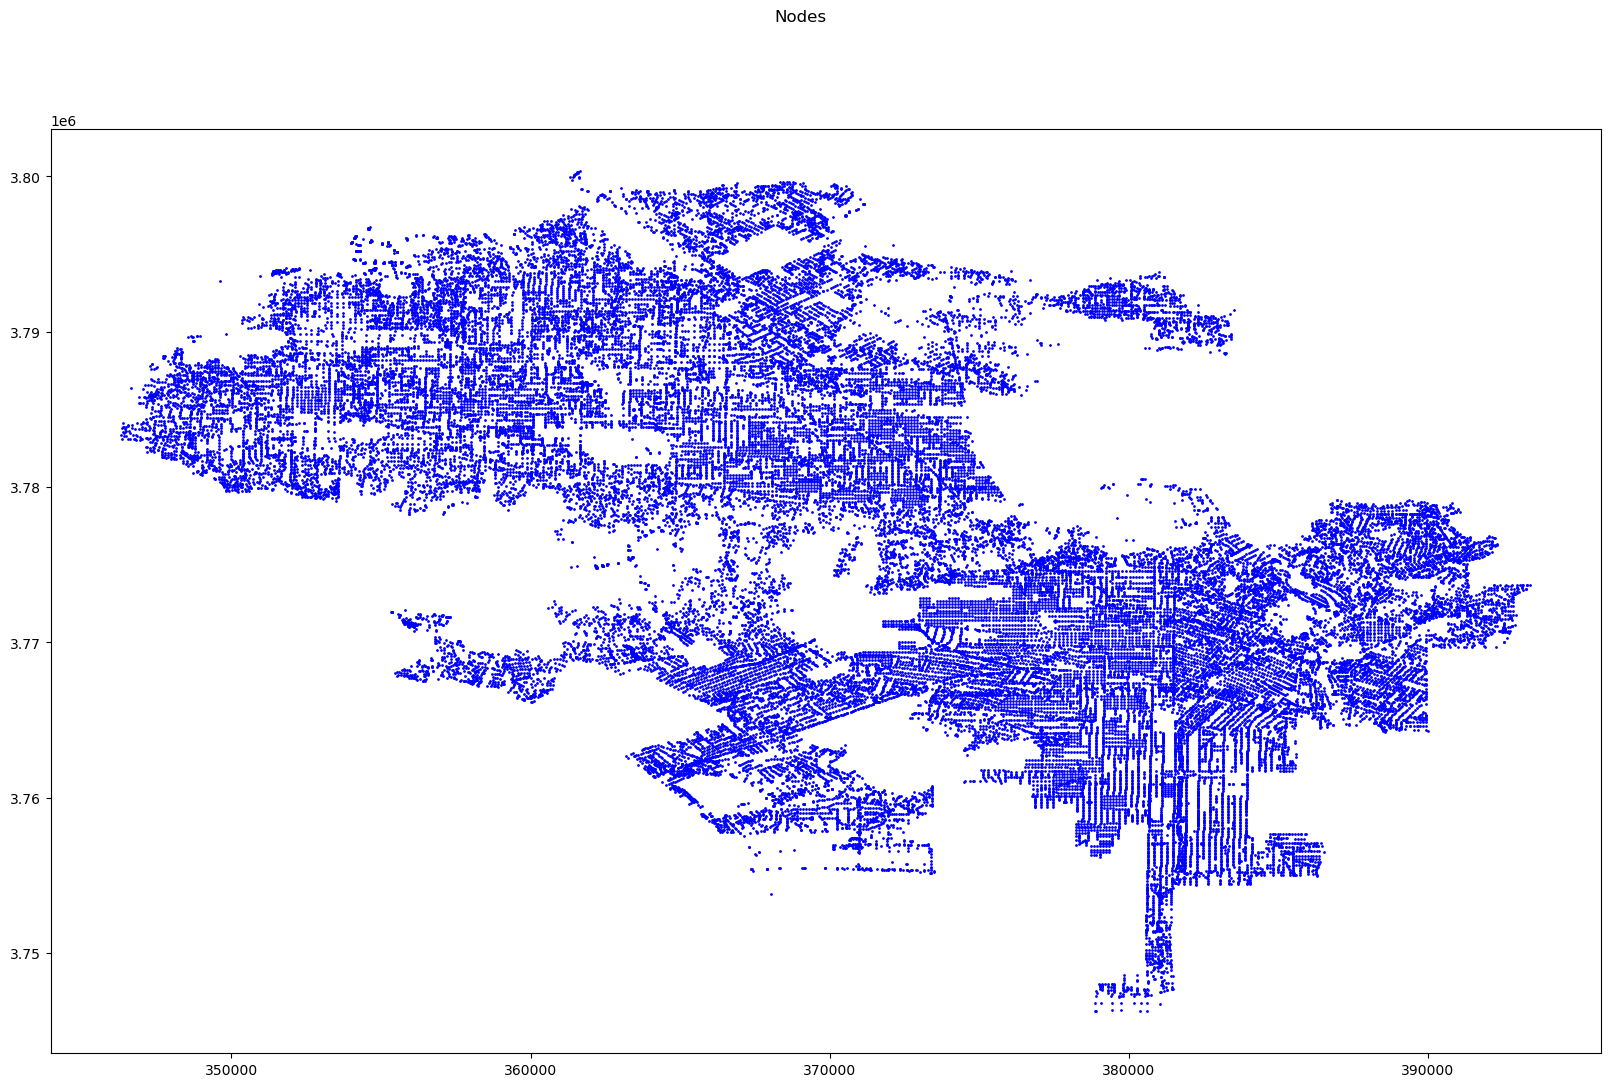

In [29]:
nodes = roads.get("NODES")

fig_nodes = plt.figure("Nodes", figsize=(20,12))
fig_nodes.suptitle("Nodes")
for id, node in nodes.items():
    x = float(node["position"][0])
    y = float(node["position"][1])
    plt.scatter(x, y, color="blue", s=1)

### Plot sections

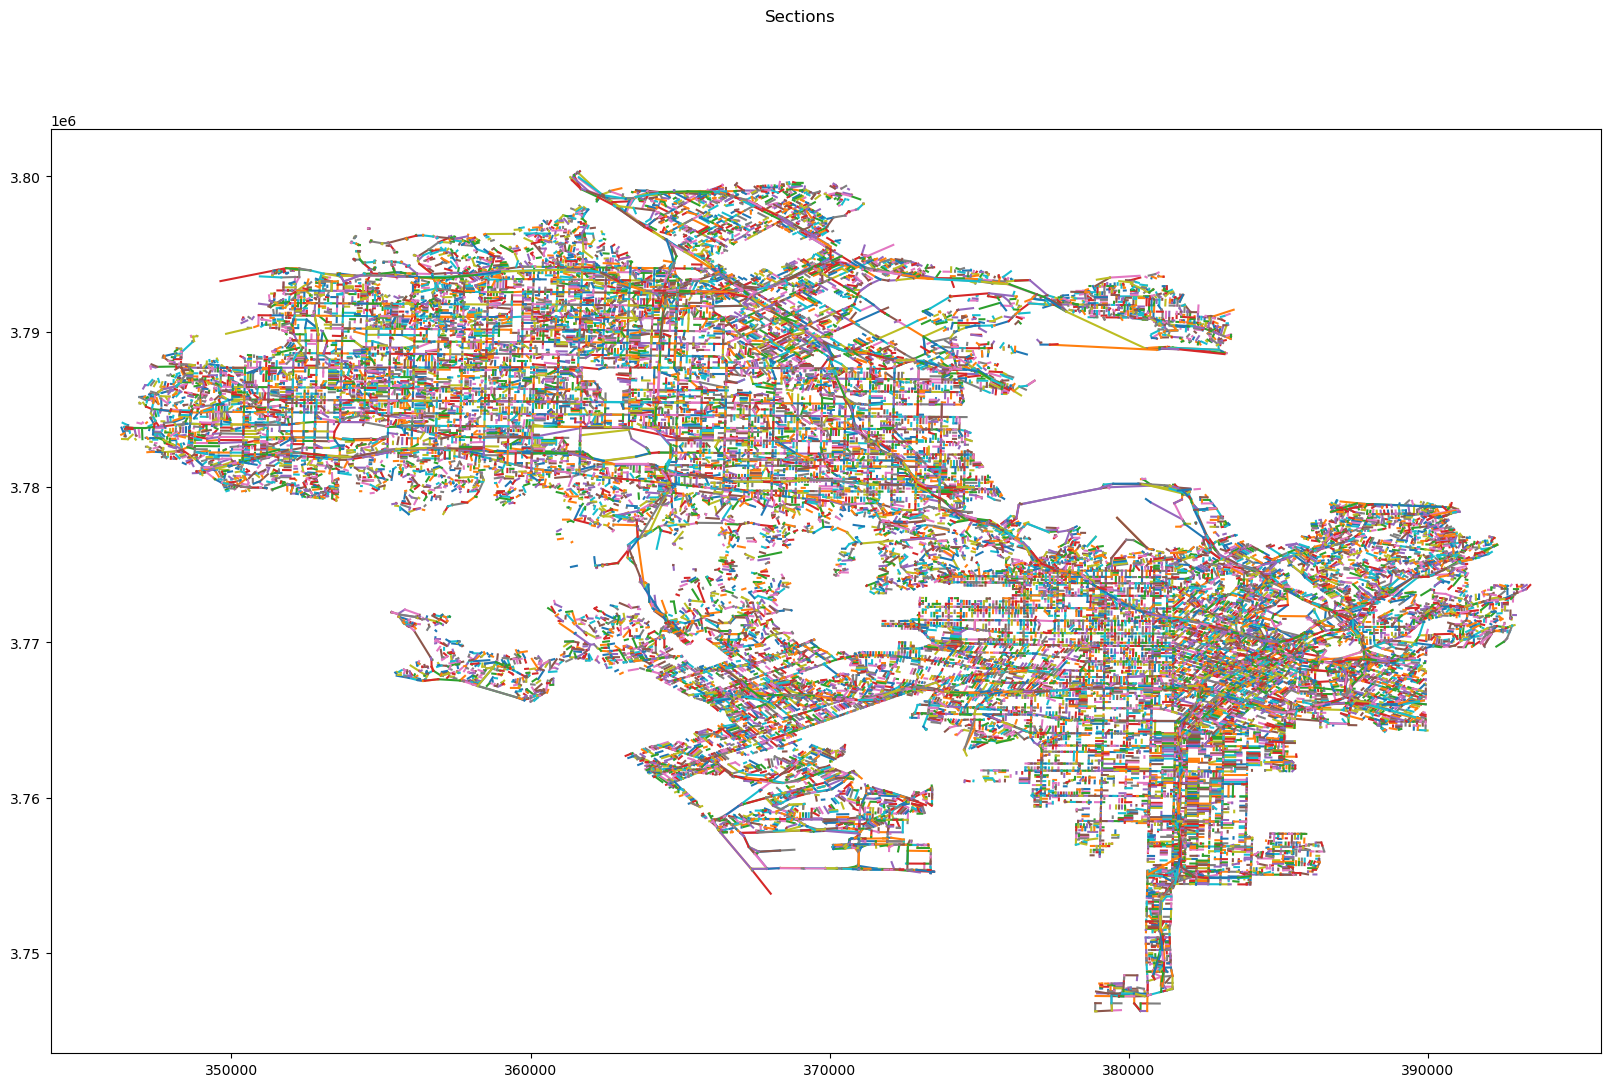

In [31]:
nodes = roads.get("NODES")
sections = roads.get("SECTIONS")

fig_sections = plt.figure("Sections", figsize=(20,12))
fig_sections.suptitle("Sections")
for id, section in sections.items():
    upnode = section["upstream"]
    downnode = section["downstream"]

    for id, node in nodes.items():
        if node["id"] == upnode:
            ux = float(node["position"][0])
            uy = float(node["position"][1])
        if node["id"] == downnode:
            dx = float(node["position"][0])
            dy = float(node["position"][1])

    plt.plot([ux, dx], [uy, dy])

## Analysis

In [37]:
stops = roads.get("STOPS")
zones = roads.get("ZONES")

### General

In [38]:
print(f"Number of nodes : {len(nodes)}")
print(f"Number of sections : {len(sections)}")
print(f"Number of sections per zone : {len(sections) / len(zones)}")

Number of nodes : 49435
Number of sections : 43342
Number of sections per zone : 43342.0


### Sections

In [39]:
sections_length = []
for id, section in sections.items():
    sections_length.append(section["length"])

In [42]:
print(f"Min length of section : {min(sections_length)}")
print(f"Max length of section : {max(sections_length)}")
print(f"Mean length of section : {mean(sections_length)}")
print(f"Median length of section : {median(sections_length)}")

print(f"Connectivity index : {len(sections) / len(nodes)}")

Min length of section : 0.278
Max length of section : 6663.559000000003
Mean length of section : 173.91748267269622
Median length of section : 120.126
Connectivity index : 0.8767472438555679


### Centralities

In [43]:
def compute_centralities(roads):
    nodes = roads.get("NODES")
    sections = roads.get("SECTIONS")
    centralities = {}

    for id, node in nodes.items():
        id_node = node["id"]
        for id, section in sections.items():
            upnode = section["upstream"]
            downnode = section["downstream"]
            if id_node == upnode:
                centralities[id_node] = centralities.get(id_node, 0) + 1
            if id_node == downnode:
                centralities[id_node] = centralities.get(id_node, 0) + 1

    return centralities

In [44]:
centralities = compute_centralities(roads)
print(f"Node with maximum centrality degree : {max(centralities, key=centralities.get)} = {max(centralities.values())}")

Node with maximum centrality degree : 18166155 = 8


In [59]:
def visualize_centralities(nodes, centralities, max_degree):
    xvalues = []
    yvalues = []
    dvalues = []

    for idc, degree in centralities.items():
        for idn, node in nodes.items():
            if idn == idc:
                node = nodes[idn]
                xvalues.append(float(node["position"][0]))
                yvalues.append(float(node["position"][1]))
                dvalues.append(float(degree))

    fig_centralities = plt.figure("Centralities", figsize=(20,12))
    fig_centralities.suptitle("Centralities")
    plt.scatter(x=xvalues, y=yvalues, c=dvalues, cmap="YlOrRd", vmin=0, vmax=max_degree, s=1)

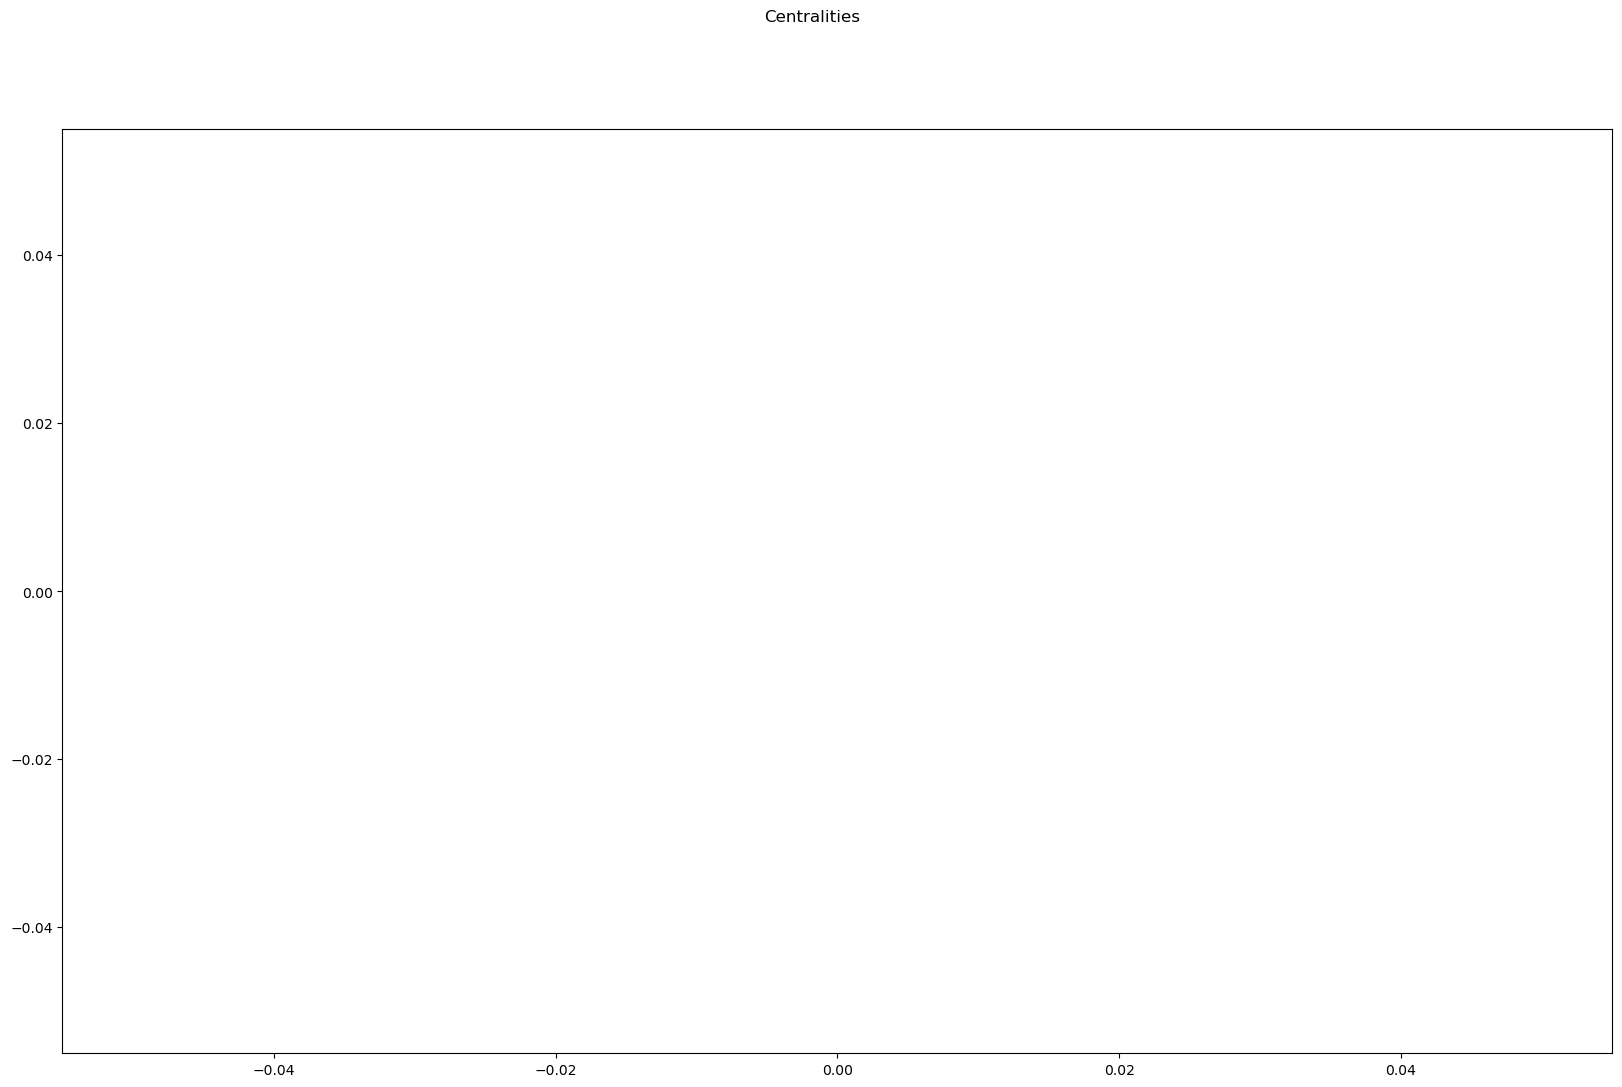

In [60]:
visualize_centralities(nodes, centralities, max(centralities.values()))